In [7]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the data

In [8]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [9]:
y.shape, tx.shape

((10000,), (10000, 2))

# Computing the Cost Function
Fill in the `compute_cost` function below:

In [10]:
def calculate_mse(e):
    """Calculate the mse for vector e."""
    return 1/2*np.mean(e**2)


def calculate_mae(e):
    """Calculate the mae for vector e."""
    return np.mean(np.abs(e))


def compute_loss(y, tx, w):
    """Calculate the loss.

    You can calculate the loss using mse or mae.
    """
    e = y - tx.dot(w)
    return calculate_mae(e)

# Grid Search

Fill in the function `grid_search()` below:

In [11]:
# from costs import *

def grid_search(y, tx, w0, w1):
    """Algorithm for grid search."""
    loss = np.zeros((len(w0), len(w1)))
    # compute loss for each combinationof w0 and w1.
    for ind_row, row in enumerate(w0):
        for ind_col, col in enumerate(w1):
            w = np.array([row, col])
            loss[ind_row, ind_col] = compute_loss(y, tx, w)
    return loss

Let us play with the grid search demo now!

Grid Search: loss*=7.5885150157040915, w0*=66.66666666666669, w1*=16.666666666666686, execution time=0.241 seconds


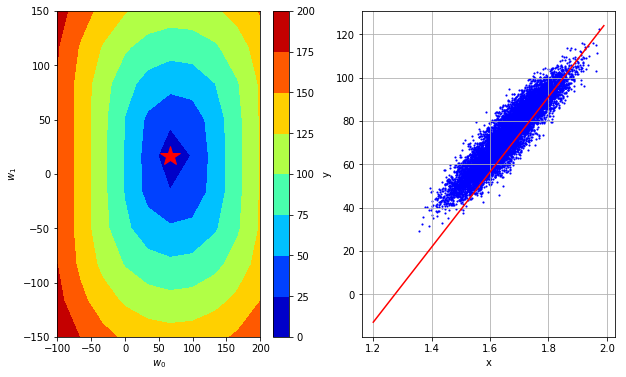

In [12]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=10)

# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print("Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
      l=loss_star, w0=w0_star, w1=w1_star, t=execution_time))

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0,6.0)
fig.savefig("grid_plot")  # Optional saving

# Gradient Descent

Again, please fill in the functions `compute_gradient` below:

In [13]:
def compute_gradient(y, tx, w):
    """Compute the gradient."""
    err = y - tx.dot(w)
    grad = -tx.T.dot(err) / len(err)
    return grad, err

Please fill in the functions `gradient_descent` below:

In [14]:
def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """Gradient descent algorithm."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # compute loss, gradient
        grad, err = compute_gradient(y, tx, w)
        loss = calculate_mse(err)
        # gradient w by descent update
        w = w - gamma * grad
        # store w and loss
        ws.append(w)
        losses.append(loss)
        print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))

    return losses, ws

Test your gradient descent function through gradient descent demo shown below:

In [15]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()
gradient_losses, gradient_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time={t:.3f} seconds".format(t=exection_time))

Gradient Descent(0/49): loss=2792.2367127591674, w0=51.30574540147352, w1=9.435798704492393
Gradient Descent(1/49): loss=265.302462108962, w0=66.69746902191565, w1=12.266538315840034
Gradient Descent(2/49): loss=37.87837955044161, w0=71.31498610804833, w1=13.115760199244338
Gradient Descent(3/49): loss=17.410212120174496, w0=72.70024123388814, w1=13.370526764265632
Gradient Descent(4/49): loss=15.568077051450455, w0=73.11581777164008, w1=13.446956733772023
Gradient Descent(5/49): loss=15.402284895265295, w0=73.24049073296567, w1=13.469885724623941
Gradient Descent(6/49): loss=15.38736360120863, w0=73.27789262136332, w1=13.476764421879517
Gradient Descent(7/49): loss=15.38602068474353, w0=73.28911318788263, w1=13.478828031056189
Gradient Descent(8/49): loss=15.385899822261674, w0=73.29247935783842, w1=13.47944711380919
Gradient Descent(9/49): loss=15.385888944638305, w0=73.29348920882516, w1=13.47963283863509
Gradient Descent(10/49): loss=15.3858879656522, w0=73.29379216412119, w1=13.47

In [16]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gradient_losses, gradient_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gradient_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# Stochastic gradient descent

In [17]:
def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient from just few examples n and their corresponding y_n labels."""
    err = y - tx.dot(w)
    grad = -tx.T.dot(err) / len(err)
    return grad, err

def stochastic_gradient_descent(
        y, tx, initial_w, batch_size, max_iters, gamma):
    """Stochastic gradient descent."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    
    for n_iter in range(max_iters):
        for y_batch, tx_batch in batch_iter(y, tx, batch_size=batch_size, num_batches=1):
            # compute a stochastic gradient and loss
            grad, _ = compute_stoch_gradient(y_batch, tx_batch, w)
            # update w through the stochastic gradient update
            w = w - gamma * grad
            # calculate loss
            loss = compute_loss(y, tx, w)
            # store w and loss
            ws.append(w)
            losses.append(loss)

        print("SGD({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))
    return losses, ws

In [18]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD(0/49): loss=57.86496498550904, w0=41.243172066887226, w1=-49.90441771413313
SGD(1/49): loss=32.39969925518188, w0=105.69362125728706, w1=6.91957325399747
SGD(2/49): loss=14.467140428314949, w0=86.90368776327276, w1=4.130550728608237
SGD(3/49): loss=14.197660153164348, w0=85.97291130656103, w1=3.0616984066672366
SGD(4/49): loss=11.22905626169308, w0=68.86294822416679, w1=2.0417101391591457
SGD(5/49): loss=9.231665618643374, w0=81.72013290044886, w1=8.699707970501414
SGD(6/49): loss=9.663753428756104, w0=82.5297037182155, w1=9.683901163837316
SGD(7/49): loss=5.4333699645189215, w0=76.34011558888321, w1=11.262880666007176
SGD(8/49): loss=4.752973515507143, w0=71.07627852890471, w1=13.679785167120812
SGD(9/49): loss=9.095584527025819, w0=64.6051421070527, w1=16.05558107952683
SGD(10/49): loss=6.850672926185416, w0=71.06126958975398, w1=19.6274926500065
SGD(11/49): loss=5.09443693352586, w0=74.11667657703299, w1=16.493626265204853
SGD(12/49): loss=5.917047121739456, w0=70.09204752248469

In [19]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses, sgd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gradient_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>